In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import copy

In [2]:
source_dir = "images/"
save_dir = "save/"

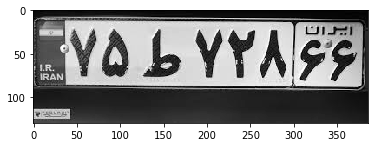

In [3]:
image = cv2.imread(source_dir + "Objects1.jpg", 0)
plt.imshow(image, cmap="gray")
plt.show()

### Canny edge detection

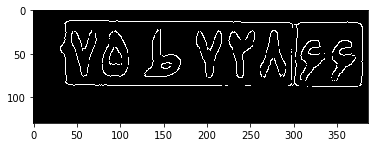

In [4]:
smoothed_image = cv2.GaussianBlur(image, (15, 15), 0)
edges = cv2.Canny(smoothed_image, 50, 230)
plt.imshow(edges, cmap="gray")

plt.savefig(save_dir + "1-edges")
plt.show()

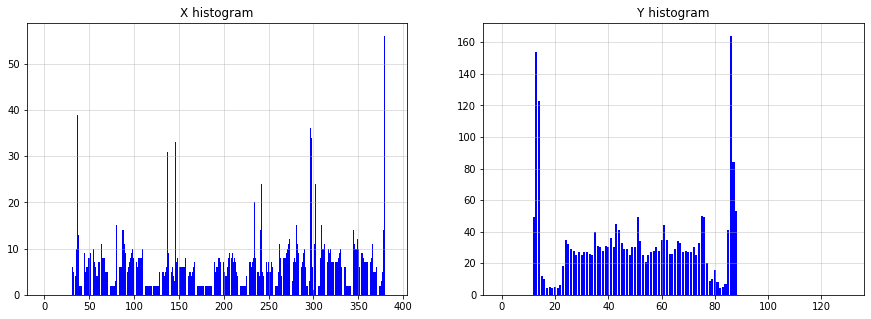

In [5]:
plt.figure(figsize=(15, 5))

x_hist = np.sum(np.where(edges != 255, edges, 1), axis=0)
y_hist = np.sum(np.where(edges != 255, edges, 1), axis=1)

plt.subplot(121)
plt.grid(alpha=0.5)
plt.bar(list(range(edges.shape[1])), x_hist, color="blue"), plt.title("X histogram")
plt.subplot(122)
plt.grid(alpha=0.5)
plt.bar(list(range(edges.shape[0])), y_hist, color="blue"), plt.title("Y histogram")

plt.savefig(save_dir + "2-initial_histogram")
plt.show()

#### Using the above histograms to crop the original image and restrict the X hostogram to the plate itself

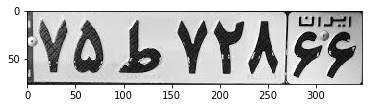

In [6]:
cropped_image = image[np.where(y_hist > 0)[0][0]:np.where(y_hist > 0)[0][-1],
                      np.where(x_hist > 0)[0][0]:np.where(x_hist > 0)[0][-1]]
plt.imshow(cropped_image, cmap="gray")
plt.savefig(save_dir + "3-cropped_plate")
plt.show()

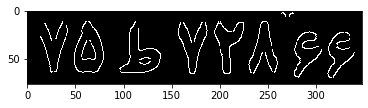

In [7]:
smoothed_image_cropped = cv2.GaussianBlur(cropped_image, (13, 13), 0)
edges_cropped = cv2.Canny(smoothed_image_cropped, 210, 250)
plt.imshow(edges_cropped, cmap="gray")
plt.savefig(save_dir + "4-canny_edges")
plt.show()

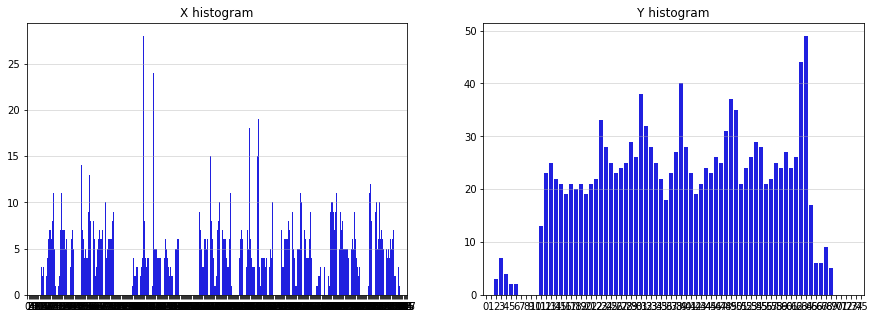

In [8]:
plt.figure(figsize=(15, 5))

x_hist = np.sum(np.where(edges_cropped != 255, edges_cropped, 1), axis=0)
y_hist = np.sum(np.where(edges_cropped != 255, edges_cropped, 1), axis=1)

plt.subplot(121)
plt.grid(alpha=0.5)
sns.barplot(list(range(edges_cropped.shape[1])), x_hist, color="blue"), plt.title("X histogram")
plt.subplot(122)
plt.grid(alpha=0.5)
sns.barplot(list(range(edges_cropped.shape[0])), y_hist, color="blue"), plt.title("Y histogram")
plt.savefig(save_dir + "5-secondary histograms")
plt.show()

### Defining the boundries
In order to make the process prone to noise, we calculate the moving average of three consecutive values.

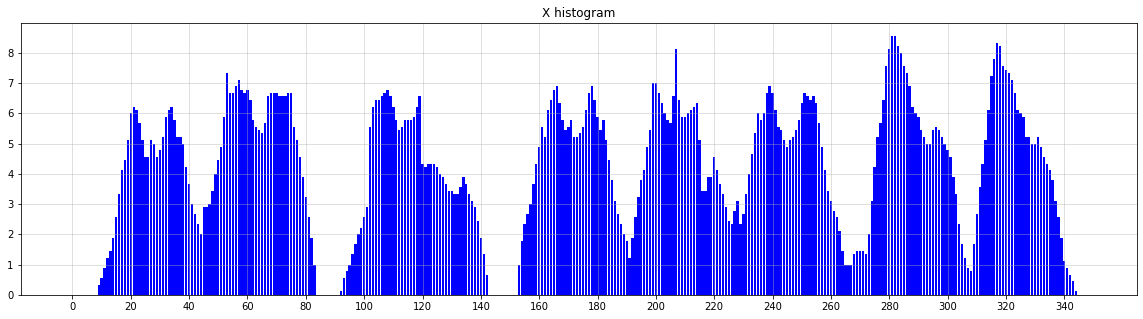

In [9]:
window_size = 9
x_hist_list = list(x_hist)

# Padding the list of the histogram to maintain its shape
x_hist_list = [0] * (window_size // 2) + x_hist_list + ([0] * (window_size // 2))

# Smoothing the histogram with a 3 windows size
averaged_list = []
for i in range(len(x_hist_list) - window_size + 1):
    averaged_list.append(sum(x_hist_list[i: i + window_size]) / window_size)
averaged_list = np.asarray(averaged_list)

# Plotting the smoothed histogram
assert averaged_list.__len__() == x_hist.__len__()
plt.figure(figsize=(20, 5))
plt.grid(alpha=0.5)
plt.bar(list(range(edges_cropped.shape[1])), averaged_list, color="blue"), plt.title("X histogram")
plt.xticks(list(range(0, edges_cropped.shape[1], 20)))

plt.savefig(save_dir + "6-smoothed_histogram")
plt.show()

In [10]:
def find_boundries(histogram, threshold=3, counter_threshold=4):
    in_boundry_region = False
    counter = 0
    boundries = []
    for i, value in enumerate(histogram):
        
        if in_boundry_region:
            counter += 1
        
        if value <= threshold and not in_boundry_region:
            begin_boundry = i
            in_boundry_region = True

        if value > threshold and counter >= counter_threshold:
            boundries.append((begin_boundry + i) // 2)
            in_boundry_region == False
            counter = 0
            
        if value > threshold and counter <= counter_threshold:
            counter = 0
            in_boundry_region = False

        # Appending the final boundry
    boundries.append((begin_boundry + i) // 2)    
    return boundries

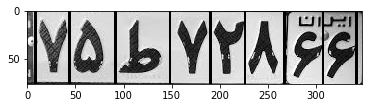

In [11]:
boundries = find_boundries(averaged_list)
cropped_image_copy = copy.deepcopy(cropped_image)
shape = cropped_image_copy.shape
for line in boundries:
    cv2.line(cropped_image_copy, (line, 0), (line, shape[1]), color = (0, 0, 255), thickness=2)
plt.imshow(cropped_image_copy, cmap="gray")
plt.show()

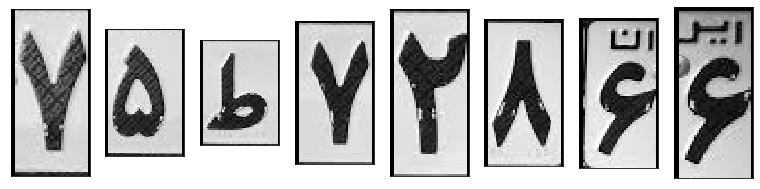

In [12]:
parts_num = len(boundries)

plt.figure(figsize=(15, 5))
for i, (start, end) in enumerate(zip(boundries[:-1], boundries[1:])):
    plt.subplot(1, parts_num, i + 1)
    plt.imshow(cropped_image_copy[:, start:end], cmap="gray"), plt.xticks([]), plt.yticks([])
    
plt.savefig(save_dir + "7-cropped_images")
plt.show()